In [1]:
import datacube
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import geopandas as gpd
from pyproj import Proj, transform
from datacube.utils.cog import write_cog
from odc.ui import with_ui_cbk

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices

In [2]:
dc = datacube.Datacube(app="Burnt_area_mapping")

In [3]:
# Define the area of interest
lat = 11.69 #12.016
lon = -4.425 #-4.475
buffer = 0.1

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

In [ ]:
start_date_pre = '2017-10-01'
end_date_pre='2017-12-01'
start_date_post ='2018-04-01'
end_date_post='2018-05-01'

In [11]:
# Define load parameters
resolution = (-30, 30)
measurements = ['blue', 'green', 'red',
                'nir', 'swir_1', 'swir_2', 'pixel_quality', 'radiometric_saturation']
#collection_category='T1'
min_gooddata = 0.6

#time = '2017-10-01', '2021-05-01'

In [12]:
# Choose the Landsat 8 products to load
products = ["ls8_sr"]

# Create a reusable query
query = {
    "x": lon_range,
    "y": lat_range,
    "resolution": resolution,
    "measurements": measurements, 
    "output_crs" : "EPSG:6933",
    #"time":time
}



In [13]:
# Load all data in basline period avalible from ARD data
baseline_ard = load_ard(dc=dc,
                        products=products,
                        min_gooddata=min_gooddata,
                        group_by='solar_day',
                        #time = '2017-12-01', '2018-04-01',
                        #collection_category=collection_category,
                        **query)

# Calculate NBR for the baseline images
baseline_ard = calculate_indices(baseline_ard,
                                 index='NBR',
                                 collection='c2',
                                 drop=False)
        

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr


/opt/conda/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class CommonTimestamp will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  return self._connection.execute(select_query)
/opt/conda/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class Float8Range will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  

Counting good quality pixels for each time step
Filtering to 52 out of 77 time steps with at least 60.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 52 time steps


In [14]:
baseline_ard

<xarray.Dataset>
Dimensions:                 (time: 52, y: 834, x: 644)
Coordinates:
  * time                    (time) datetime64[ns] 2017-10-04T10:39:04.668149 ...
  * y                       (y) float64 1.494e+06 1.494e+06 ... 1.469e+06
  * x                       (x) float64 -4.366e+05 -4.366e+05 ... -4.173e+05
    spatial_ref             int32 6933
Data variables:
    blue                    (time, y, x) float32 0.02786 0.026 ... 0.08017
    green                   (time, y, x) float32 0.06922 0.06834 ... 0.1326
    red                     (time, y, x) float32 0.07434 0.06953 ... 0.1909
    nir                     (time, y, x) float32 0.3209 0.2987 ... 0.3288 0.3331
    swir_1                  (time, y, x) float32 0.2108 0.2122 ... 0.4093 0.4036
    swir_2                  (time, y, x) float32 0.1104 0.1154 ... 0.3147 0.3053
    pixel_quality           (time, y, x) uint16 21824 21824 ... 21824 21824
    radiometric_saturation  (time, y, x) uint16 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    NBR                     (time, y, x) float32 0.4881 0.4427 ... 0.04359
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [23]:
# Compute median using all observations in the dataset along the time axis
baseline_image = baseline_ard.median(dim=(time=slice('2017-10-04','2017-12-31')))
baseline_image_min = baseline_ard.min(dim='time')

# Select NBR
baseline_NBR = baseline_image.NBR
baseline_NBR_min = baseline_image_min.NBR

SyntaxError: invalid syntax (3308804570.py, line 2)

In [36]:
baseline_2017 = baseline_ard.sel(time=slice('2017-10-04','2017-12-31'))
baseline_2017_image= baseline_2017.median(dim='time')
baseline_2017_NBR = baseline_2017_image.NBR


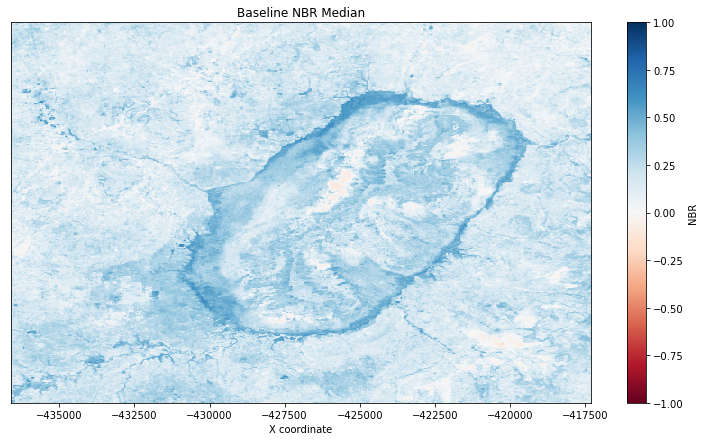

In [37]:
f, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))
baseline_2017_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Baseline NBR Median')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')

plt.show()

NameError: name 'baseline_NBR' is not defined

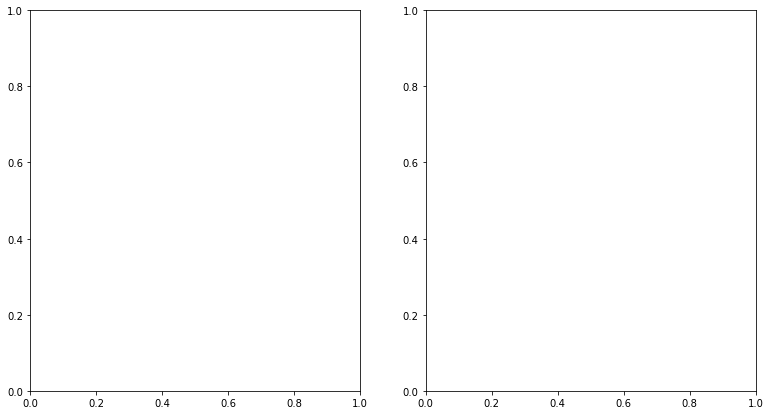

In [34]:
# Visualise baseline image as true colour image
"""f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))
rgb(baseline_image,
    bands=['red', 'green', 'blue'],
    ax=ax1)
ax1.set_title('Baseline RGB')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
plt.show()"""

# Set up subplots
f, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))


# Visualise baseline image as NBR image
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Baseline NBR Median')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')

# Visualise baseline minimum image as NBR image
baseline_NBR_min.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax3)
ax3.set_title('Baseline NBR Minimum')
ax3.yaxis.set_visible(False)
ax3.set_xlabel('X coordinate')

plt.show()